In [1]:
import glob
import os
import cv2
import glob
import importlib
import h5py
import json
import copy
import _pickle as pkl
import numpy as np
import pandas as pd
import seaborn as sns
import pylab as pl

In [164]:
import scipy.stats as spstats
import analyze2p.utils as hutils
import analyze2p.plotting as pplot
import analyze2p.receptive_fields.utils as rfutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.scatter as sct
import analyze2p.retinotopy.segment as seg


In [165]:
rootdir = '/n/coxfs01/2p-data'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
# Plotting
pplot.set_plot_params()
visual_areas, area_colors = pplot.set_threecolor_palette()

In [166]:
# Receptive Field settings
traceid='traces001'
response_type='dff'
do_spherical_correction=True
is_neuropil = False
# ---------------------------------------------------
fit_desc = rfutils.get_fit_desc(response_type=response_type,
                               do_spherical_correction=do_spherical_correction)
data_id = '%s|%s' % (traceid, fit_desc)
data_id

'traces001|fit-2dgaus_dff_sphr'

In [167]:
# output dir
rf_str = 'sphr_corrected' if do_spherical_correction else ''
dst_dir = os.path.join(aggregate_dir, 'receptive-fields', 'scatter/%s' % rf_str)
print(dst_dir)
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/scatter/sphr_corrected


In [168]:
# Meta data
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
meta = sdata[sdata.experiment.isin(['rfs', 'rfs10'])].copy()

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 13 dsets


In [169]:
rfdf = rfutils.aggregate_fits(cells0, meta, combine='single', 
                              response_type=response_type,
                              do_spherical_correction=do_spherical_correction,
                              reliable_only=True,
                              pass_criterion='position')

N dpaths: 62, N unfit: 0
N datasets included: 67, N sessions excluded: 4
ERROR: No RF evaluations for - 20190522_JC084_fov1 (fit-2dgaus_dff_sphr)
ERROR: No RF evaluations for - 20190615_JC097_fov2 (fit-2dgaus_dff_sphr)


In [170]:
rfdf.groupby('visual_area').count()

,x0,y0,fwhm_x,fwhm_y,theta,offset,amplitude,r2,cell,datakey,...,theta_c,theta_Mm_deg,major_axis,minor_axis,anisotropy,theta_Mm_c,aniso_index,rf_theta_deg,aspect_ratio,eccentricity
visual_area,,,,,,,,,,,,,,,,,,,,,
Li,483,483,483,483,483,483,483,483,483,483,...,483,483,483,483,483,483,483,483,483,483
Lm,371,371,371,371,371,371,371,371,371,371,...,371,371,371,371,371,371,371,371,371,371
V1,572,572,572,572,572,572,572,572,572,572,...,572,572,572,572,572,572,572,572,572,572


# Aggregate deviants

In [124]:
rf_fit_desc = rfutils.get_fit_desc(response_type=response_type,
                                  do_spherical_correction=do_spherical_correction)
deviants, no_results = sct.aggregate_deviant_cells(response_type=response_type,
                             do_spherical_correction=do_spherical_correction, meta=meta, 
                             traceid=traceid,
                             create_new=True, redo_fov=False)

ERROR: V1, 20190504_JC078_fov1 -- cond=az
ERROR: V1, 20190504_JC078_fov1 -- cond=el


Traceback (most recent call last):
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/scatter.py", line 308, in get_deviants_in_fov
    ax, devs_ = fit_with_deviants(boot_, cis_, rfs_)
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/scatter.py", line 109, in fit_with_deviants
    e1 = err_bands[0, :] # err_bands[0, np.argsort(xvals)] <- sort by xpos to plot
IndexError: too many indices for array
Traceback (most recent call last):
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/scatter.py", line 308, in get_deviants_in_fov
    ax, devs_ = fit_with_deviants(boot_, cis_, rfs_)
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/scatter.py", line 109, in fit_with_deviants
    e1 = err_bands[0, :] # err_bands[0, np.argsort(xvals)] <- sort by xpos to plot
Ind

ERROR: No RF evaluations for - 20190522_JC084_fov1 (fit-2dgaus_dff_sphr)
ERROR: No RF evaluations for - 20190615_JC097_fov2 (fit-2dgaus_dff_sphr)


In [125]:
no_results

[('V1', '20190522_JC084_fov1', 'rfs'), ('V1', '20190615_JC097_fov2', 'rfs10')]

In [126]:
for (va, dk), g in meta.groupby(['visual_area', 'datakey']):
    if deviants.query('@va==visual_area and @dk==datakey').empty:
        print(va, dk)

Li 20190522_JC089_fov1
Li 20190617_JC099_fov1
Li 20191012_JC113_fov1
Li 20191018_JC113_fov1
Li 20191111_JC120_fov1
Lm 20190423_JC076_fov1
Lm 20190504_JC078_fov1
Lm 20190509_JC078_fov1
Lm 20191105_JC117_fov1
Lm 20191111_JC117_fov1
Lm 20191111_JC117_fov2
V1 20190508_JC083_fov1
V1 20190509_JC078_fov1
V1 20190512_JC083_fov1
V1 20190517_JC083_fov1
V1 20190522_JC084_fov1
V1 20190615_JC097_fov2
V1 20191111_JC117_fov1


In [127]:
# df_ = sct.load_scatter_results(dk, va, exp, verbose=False)
# df_

# Load all results from scatter analysis

In [128]:
missing=[]
d_list=[]
no_eval=[]
for (va, dk, exp), g in meta.groupby(['visual_area', 'datakey', 'experiment']):
    # Load scatter calculations
    df_ = sct.load_scatter_results(dk, va, exp, verbose=False)
    if df_ is None:
        missing.append((va, dk, exp))
        continue
    # get reliable or not
    eval_results, eval_params = rfutils.load_eval_results(dk,
                                    experiment=exp, 
                                    traceid=traceid, 
                                    fit_desc=fit_desc)   
    if eval_results is None:
        no_eval.append((dk, va, exp))
        continue
    reliable_ = rfutils.get_reliable_fits(eval_results['pass_cis'],
                                        pass_criterion='position')
    # Assign reliable index
    found_rois = df_['cell'].unique()
    df_['reliable'] = False
    df_.loc[df_['cell'].isin(reliable_), 'reliable'] = True
    # Get deviant or not
    curr_deviants = deviants[(deviants.visual_area==va) 
                          & (deviants.datakey==dk)].copy()
    df_['deviant'] = False
    for dev_cond, dev_vals in curr_deviants.groupby(['axis']):
        dev_rois = dev_vals['deviants'].values
        df_.loc[(df_.axis==dev_cond) \
                & (df_['cell'].isin(dev_rois)), 'deviant'] = True
    df_['visual_area'] = va
    df_['datakey'] = dk
    df_['experiment'] = exp
    d_list.append(df_)
scatterdf = pd.concat(d_list, axis=0)
scatterdf.shape
print("Missing %i datasets:" % (len(missing)))
for m in missing:
    print(m)

ERROR: No RF evaluations for - 20190522_JC084_fov1 (fit-2dgaus_dff_sphr)
ERROR: No RF evaluations for - 20190615_JC097_fov2 (fit-2dgaus_dff_sphr)
Missing 2 datasets:
('Lm', '20191105_JC117_fov1', 'rfs10')
('Lm', '20191111_JC120_fov1', 'rfs10')


In [162]:
scatterdf.groupby(['visual_area', 'axis']).count()

cell  deg_scatter  dist_scatter  inbounds  reliable  \
visual_area axis                                                        
Li          az     568          568           568       568       568   
            el     568          568           568       568       568   
Lm          az     429          429           429       429       429   
            el     429          429           429       429       429   
V1          az     947          947           947       947       947   
            el     947          947           947       947       947   

                  deviant  datakey  experiment  
visual_area axis                                
Li          az        568      568         568  
            el        568      568         568  
Lm          az        429      429         429  
            el        429      429         429  
V1          az        947      947         947  
            el        947      947         947

In [163]:
scatterdf[scatterdf.reliable].groupby(['visual_area', 'axis']).count()

cell  deg_scatter  dist_scatter  inbounds  reliable  \
visual_area axis                                                        
Li          az     500          500           500       500       500   
            el     500          500           500       500       500   
Lm          az     376          376           376       376       376   
            el     376          376           376       376       376   
V1          az     869          869           869       869       869   
            el     869          869           869       869       869   

                  deviant  datakey  experiment  
visual_area axis                                
Li          az        500      500         500  
            el        500      500         500  
Lm          az        376      376         376  
            el        376      376         376  
V1          az        869      869         869  
            el        869      869         869

In [129]:
# for (va, dk, exp) in missing:
#     devs = sct.do_scatter_analysis(dk, va, experiment=exp, 
#                                 do_gradients=False, do_model=False)


In [130]:
count_cols=['visual_area', 'datakey', 'experiment', 'cell']
fit_ = aggr.count_n_cells(scatterdf, name='fit', count_cols=count_cols, reset_index=False)
reliable_ = aggr.count_n_cells(scatterdf[scatterdf['reliable']], name='reliable', 
                               count_cols=count_cols, reset_index=False)
deviants_ = aggr.count_n_cells(scatterdf[scatterdf['deviant']], name='deviant', 
                              count_cols=count_cols, reset_index=False) 
# Get counts
counts0 = fit_.merge(reliable_, left_index=True, right_index=True, how='outer')
count_dev = counts0.merge(deviants_, left_index=True, right_index=True, how='outer')
count_dev = count_dev.fillna(value=0).reset_index()
count_dev['fraction_reliable'] = count_dev['reliable']/count_dev['fit'].astype(float)
count_dev['fraction_deviant'] = count_dev['deviant']/count_dev['fit'].astype(float)

<IPython.core.display.Javascript object>


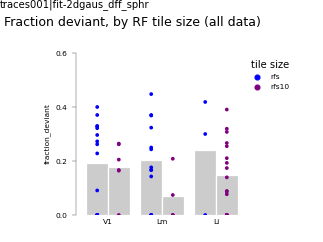

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/scatter/sphr_corrected fraction_deviant_alldata


In [132]:
%matplotlib notebook
exp_colors={'rfs': 'blue', 'rfs10': 'purple'}
fig, ax = pl.subplots(figsize=(4,3))
fig.set_facecolor('1')
#exp_colors = {'rfs': [0.7]*3, 'rfs10': [0.4]*3}
# exp_colors = {'rfs': 'blue', 'rfs10': 'purple'}
sns.stripplot(x='visual_area', y='fraction_deviant', data=count_dev, ax=ax,
              hue='experiment', palette=exp_colors, dodge=True, 
              order=visual_areas, jitter=False,size=3)
sns.barplot(x='visual_area', y='fraction_deviant', data=count_dev, ax=ax,
              hue='experiment', palette={'rfs': [0.8]*3, 'rfs10': [0.8]*3}, 
             edgecolor='w',ci=None, order=visual_areas)
pplot.crop_legend_labels(ax, 2,start_ix=0, bbox_to_anchor=(1, 1), loc='upper left',
        fontsize=6, title='tile size', markerscale=0.5)
ax.set_box_aspect(1)
ax.set_yticks(np.linspace(0, 0.6, 4))
ax.set_ylim([0, 0.6])
ax.set_xlabel('')
ax.tick_params(which='both', axis='x', size=0)
sns.despine(bottom=True, offset=4, trim=True)
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.2, top=0.8)

pplot.label_figure(fig, data_id)
fig.text(0.01, 0.9, "Fraction deviant, by RF tile size (all data)")

figname = 'fraction_deviant_alldata' 
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


In [133]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/scatter/sphr_corrected'

## Load REGR for retino gradients

In [134]:
import analyze2p.stats as pstats

In [135]:
bw_colors=dict((v, [0.7]*3) for v in visual_areas)
axis_colors={'az': [0.7]*3,
             'el': [0.5]*3}
exp_colors={'rfs':'blue', 'rfs10': 'purple'}

In [136]:
r_=[]
for (va, dk), g in meta.groupby(['visual_area', 'datakey']):
    regr_ = sct.load_models(dk, va)
    regr_['visual_area'] = va
    regr_['datakey'] = dk
    r_.append(regr_)
REGR = pd.concat(r_, axis=0)

In [137]:
# Only get ones that pass 
r2_thr=0.5
pass_regr = pd.concat([r for (va, dk), r in REGR.groupby(['visual_area', 'datakey'])\
                       if (round(r[r.cond=='az']['R2'].values[0], 1)>=r2_thr) 
                       and (round(r[r.cond=='el']['R2'].values[0], 1)>=r2_thr)])
#### Only include dataset if gradient was well-fit
scatter_pass_regr = pd.concat([g for (va, dk), g in scatterdf[scatterdf['reliable']]\
                    .groupby(['visual_area', 'datakey'])\
           if not pass_regr.query('@va==visual_area and @dk==datakey').empty])\
            .reset_index(drop=True)
# Only get ones that pass 
REGR.shape, pass_regr.shape

((108, 9), (76, 9))

In [138]:
pass_r = REGR[REGR.visual_area=='Li']['datakey'].unique()
np.unique([k for k in pass_r if k \
     not in pass_regr[pass_regr.visual_area=='Li']['datakey'].unique()])


array(['20190528_JC092_fov1', '20191012_JC113_fov2',
       '20191105_JC117_fov1'], dtype='<U19')

In [139]:
pass_regr.groupby(['visual_area', 'cond']).count()

R2  RMSE  pearson_p  pearson_r  coefficient  intercept  \
visual_area cond                                                           
Li          az    14    14         14         14           14         14   
            el    14    14         14         14           14         14   
Lm          az    12    12         12         12           12         12   
            el    12    12         12         12           12         12   
V1          az    12    12         12         12           12         12   
            el    12    12         12         12           12         12   

                  datakey  
visual_area cond           
Li          az         14  
            el         14  
Lm          az         12  
            el         12  
V1          az         12  
            el         12

#### 1 experiment per fov only

In [140]:
scatter_pass_regr['n_cells'] = None
min_ncells = 5
f_=[]
for (va, dk), g in scatter_pass_regr.groupby(['visual_area', 'datakey']):
#     if va=='Lm' and dk in['20190430_JC078_fov1', '20190508_JC083_fov1']:
#         continue
    if va in ['V1', 'Lm']:
        if 'rfs' in g['experiment'].values:
            df_ = g[g.experiment=='rfs'].copy()
        elif 'rfs10' in g['experiment'].values:
            df_ = g[g.experiment=='rfs10'].copy()
    elif va=='Li':
        if 'rfs10' in g['experiment'].values:
            df_ = g[g.experiment=='rfs10'].copy()
        elif 'rfs' in g['experiment'].values:
            df_ = g[g.experiment=='rfs'].copy()
    if len(df_['cell'].unique())<min_ncells:
        print("    too few cells: %s, %s" % (va, dk))
        continue
    df_['n_cells'] = len(df_['cell'].unique())
    # passdf.loc[g.index, 'n_cells'] = len(g['cell'].unique())
    f_.append(df_)
scatter_regr = pd.concat(f_, axis=0)

    too few cells: Li, 20191012_JC113_fov1
    too few cells: Li, 20191111_JC120_fov1


In [141]:
scatter_regr.groupby(['visual_area']).count()

,cell,deg_scatter,dist_scatter,inbounds,axis,reliable,deviant,datakey,experiment,n_cells
visual_area,,,,,,,,,,
Li,820,820,820,820,820,820,820,820,820,820
Lm,628,628,628,628,628,628,628,628,628,628
V1,908,908,908,908,908,908,908,908,908,908


In [142]:
# drop duplicates
counts = aggr.count_n_cells(scatter_regr)
u_dkeys = aggr.drop_repeats(counts, colname='n_cells')

finaldf = pd.concat([g for (va, dk), g in scatter_regr.groupby(['visual_area', 'datakey'])\
                    if (va, dk) in u_dkeys])
print(scatter_regr.shape, finaldf.shape)

(2356, 11) (1726, 11)


In [143]:
k1 = finaldf['datakey'].unique()
k0 = scatter_regr['datakey'].unique()
len(k1), len(k0)

(22, 33)

In [144]:
va='Lm'
np.unique([k for k in scatter_regr[scatter_regr.visual_area==va]['datakey'] \
 if k not in finaldf[finaldf.visual_area==va]['datakey'].values])

array(['20190506_JC080_fov1', '20190509_JC078_fov1',
       '20190512_JC083_fov1', '20190513_JC078_fov1',
       '20190517_JC083_fov1'], dtype='<U19')

In [145]:
importlib.reload(pplot)
%matplotlib notebook

| visual_area   |   datakey |
|:--------------|----------:|
| Li            |         8 |
| Lm            |         6 |
| V1            |         8 |


<IPython.core.display.Javascript object>


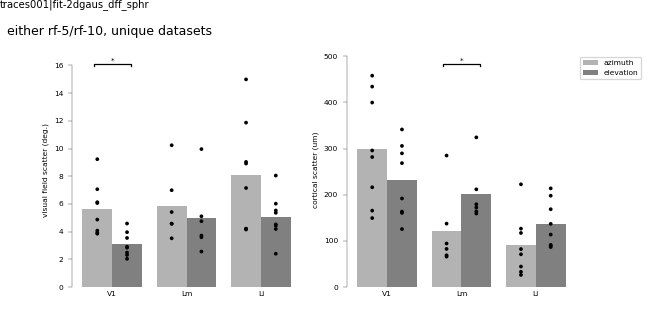

   t_stat     p_val visual_area       metric
0     1.0  0.015625          V1  deg_scatter
   t_stat    p_val visual_area        metric
1     0.0  0.03125          Lm  dist_scatter
/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/scatter/sphr_corrected scatter_perFOV_reliable


,t_stat,p_val,visual_area,metric
0,1.0,0.015625,V1,deg_scatter
1,1.0,0.062500,Lm,deg_scatter
2,4.0,0.054688,Li,deg_scatter
0,5.0,0.078125,V1,dist_scatter
1,0.0,0.031250,Lm,dist_scatter
2,6.0,0.109375,Li,dist_scatter


In [146]:
plotd = finaldf.groupby(['visual_area', 'datakey', 'axis']).mean().reset_index()
print(plotd[['visual_area', 'datakey']]\
      .drop_duplicates().groupby(['visual_area']).count()['datakey'].to_markdown())
s_=[]
fig, axn = pl.subplots(1,2, figsize=(8, 4))
fig.patch.set_facecolor('w')
for ai, metric in enumerate(['deg_scatter', 'dist_scatter']):
    ax=axn[ai]
    sns.barplot(x='visual_area', y=metric, data=plotd, ax=ax,
              order=visual_areas, hue='axis', palette=axis_colors, ci=None)
    sns.stripplot(x='visual_area', y=metric, data=plotd, ax=ax,
              order=visual_areas, hue='axis', dodge=True,
              jitter=False, size=3,
              palette=dict((k, 'k') for k in ['az', 'el']))
    ylabel = 'cortical scatter (um)' if metric=='dist_scatter' \
                else 'visual field scatter (deg.)'
    ax.set_ylabel(ylabel)
    if metric=='dist_scatter':
        offset=20; h=5;
    else:
        offset=1; h=.1;
    # stats
    stats_ = pstats.paired_ttests(plotd, metric=metric, c1='az', c2='el',
                                        compare_var='axis', ttest=False)
    stats_['metric'] = metric
    s_.append(stats_)
    pplot.annotate_sig_on_paired_plot(ax, plotd, stats_, metric, offset=offset, h=h)
    ax.legend_.remove()
statdf = pd.concat(s_)
# custom legend
leg_h = pplot.custom_legend_markers(colors=[axis_colors['az'], axis_colors['el']],
                                   labels=['azimuth', 'elevation'],
                                    use_patch=True)
ax.legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper left')

pl.subplots_adjust(left=0.1, right=0.8, wspace=0.2, bottom=0.2, top=0.85)
sns.despine(bottom=True, trim=True)
for ax in axn:
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xlabel('')

pplot.label_figure(fig, data_id)
fig.text(0.01, 0.9, 'either rf-5/rf-10, unique datasets')
    
figname = 'scatter_perFOV_reliable'
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)
statdf

<IPython.core.display.Javascript object>


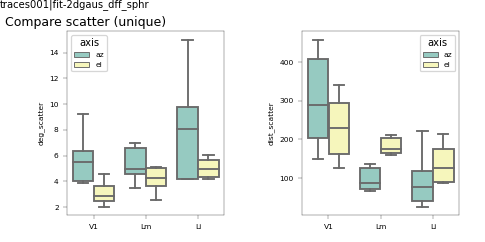

In [147]:
fig, axn = pl.subplots(1, 2, figsize=(6,3))
ax=axn[0]
sns.boxplot(x='visual_area', y='deg_scatter', hue='axis', data=plotd, 
            order=visual_areas, palette='Set3', fliersize=0, ax=ax)
ax=axn[1]
sns.boxplot(x='visual_area', y='dist_scatter', hue='axis', data=plotd, 
            order=visual_areas, palette='Set3', fliersize=0, ax=ax)
for ax in axn:
    ax.set_xlabel('')
pl.subplots_adjust(bottom=0.2, right=0.85, wspace=0.5)
fig.text(0.01, 0.9, 'Compare scatter (unique)')
pplot.label_figure(fig, data_id)


## Check paired

In [148]:
importlib.reload(pplot)
%matplotlib inline

   t_stat  p_val visual_area       metric
0     1.0  0.016          V1  deg_scatter
   t_stat  p_val visual_area        metric
1     0.0  0.031          Lm  dist_scatter
|    |   t_stat |   p_val | visual_area   | metric       |
|---:|---------:|--------:|:--------------|:-------------|
|  0 |        1 |   0.016 | V1            | deg_scatter  |
|  1 |        1 |   0.062 | Lm            | deg_scatter  |
|  2 |        4 |   0.055 | Li            | deg_scatter  |
|  0 |        5 |   0.078 | V1            | dist_scatter |
|  1 |        0 |   0.031 | Lm            | dist_scatter |
|  2 |        6 |   0.109 | Li            | dist_scatter |


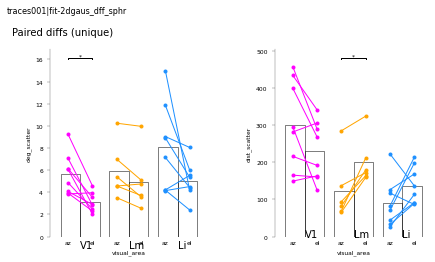

In [149]:
plotd = finaldf.groupby(['visual_area', 'datakey', 'axis']).mean().reset_index()

# Paired: spstats.wilcoxon()
offset=2
fig, axn = pl.subplots(1,2, figsize=(6.5, 4))
fig.patch.set_facecolor('w')

s_=[]
for ai, metric in enumerate(['deg_scatter', 'dist_scatter']):
    ax=axn[ai]
    ax, stats_ = pplot.pairwise_compare_single_metric(plotd, 
                 curr_metric=metric, ax=ax, size=3,
                 c1='az', c2='el', compare_var='axis', 
                 ttest=False, return_stats=True, bar_ci=None)
    stats_['metric'] = metric
    if metric=='dist_scatter':
        offset=20; h=2;
    else:
        offset=1; h=.1;
    pplot.annotate_sig_on_paired_plot(ax, plotd, stats_, metric, offset=offset, h=h)
    s_.append(stats_)
statsdf = pd.concat(s_)
print(statsdf.to_markdown())
pl.subplots_adjust(left=0.1, right=0.9, wspace=0.5, bottom=0.2, top=0.85)
fig.text(0.01, 0.9, 'Paired diffs (unique)')

pplot.label_figure(fig, data_id)
figname = 'scatter_perFOV_paired_reliable'
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

# Cortical magnification

In [150]:
import analyze2p.stats as pstats
import statsmodels.api as sm
import pingouin as pg

In [151]:
regr_df = pd.concat([g for (va, dk), g in pass_regr.groupby(['visual_area', 'datakey'])\
                     if (va, dk) in u_dkeys])
print(regr_df[['visual_area', 'datakey']]\
      .drop_duplicates()['visual_area'].value_counts().to_markdown())
regr_df['cortical_mag'] = np.abs(1./regr_df['coefficient'])

|    |   visual_area |
|:---|--------------:|
| V1 |             8 |
| Li |             8 |
| Lm |             6 |


In [152]:
cmag_df = regr_df[['visual_area','datakey']].drop_duplicates().reset_index(drop=True)
cmag_df['cortical_mag'] = None
cmag_df['cortical_mag_ratio'] = None
for (va, dk), cg in cmag_df.groupby(['visual_area', 'datakey']):
    r_df = regr_df[(regr_df.visual_area==va) & (regr_df.datakey==dk)].copy()
    mean_mag = r_df['coefficient'].abs().mean()
    ratio_mag = float(r_df[r_df.cond=='el']['cortical_mag'])\
                /float(r_df[r_df.cond=='az']['cortical_mag'])
    cmag_df.loc[cg.index, 'cortical_mag'] = mean_mag
    cmag_df.loc[cg.index, 'cortical_mag_ratio'] = ratio_mag
cmag_df['cortical_mag'] = abs(cmag_df['cortical_mag'].astype(float))
cmag_df['cortical_mag_ratio'] = abs(cmag_df['cortical_mag_ratio'].astype(float))

In [153]:
regr_df.groupby('visual_area')['cortical_mag'].describe()

,count,mean,std,min,25%,50%,75%,max
visual_area,,,,,,,,
Li,16.0,19.181685,10.257885,6.198124,8.778001,19.657937,25.484911,37.112674
Lm,12.0,32.156342,15.510576,13.473201,18.540987,29.940195,45.375611,62.144282
V1,16.0,65.058058,24.603603,36.659333,46.354382,59.119355,75.309401,132.101334


In [154]:
regr_df.groupby(['visual_area', 'cond'])['cortical_mag'].describe()

count       mean        std        min        25%  \
visual_area cond                                                      
Li          az      8.0  10.871074   4.964207   6.198124   7.433560   
            el      8.0  27.492296   6.555256  20.573945  22.202969   
Lm          az      6.0  19.739409   5.692121  13.473201  15.793353   
            el      6.0  44.573276  11.262268  32.071447  35.543495   
V1          az      8.0  52.852608  13.799842  36.659333  44.000831   
            el      8.0  77.263507  27.680426  40.516312  60.306488   

                        50%        75%         max  
visual_area cond                                    
Li          az     8.460852  14.834979   18.741929  
            el    25.837573  32.523382   37.112674  
Lm          az    18.372763  23.699616   27.808944  
            el    46.221048  48.153402   62.144282  
V1          az    47.897835  60.371808   74.731122  
            el    75.747630  84.882847  132.101334

<IPython.core.display.Javascript object>


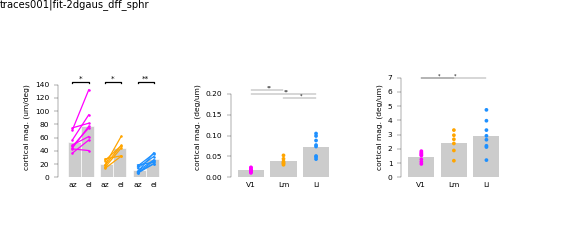

   t_stat  p_val visual_area
2     0.0  0.008          Li
   t_stat  p_val visual_area
1     0.0  0.031          Lm
   t_stat  p_val visual_area
0     1.0  0.016          V1
/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/scatter/sphr_corrected


In [155]:
%matplotlib notebook
s_=[]
fig, axn = pl.subplots(1,3, figsize=(7,3))
fig.patch.set_facecolor('w')
ax=axn[0]
metric='cortical_mag'
ax, stats_ = pplot.pairwise_compare_single_metric(regr_df, 
                 curr_metric=metric, ax=ax, size=1,
                 c1='az', c2='el', compare_var='cond', 
                 ttest=False, return_stats=True, bar_ci=None,
                 facecolor=[0.8]*3, edgecolor='w', label_areas=False)
pl.subplots_adjust(bottom=.2)
pplot.annotate_sig_on_paired_plot(ax, regr_df, stats_, metric, offset=10, h=2)
# pplot.crop_legend_labels(ax, 2, start_ix=2, markerscale=0.1, 
#                         bbox_to_anchor=(1,1), loc='upper right', fontsize=6)
ax.set_box_aspect(1)
ax.tick_params(which='both', axis='x', size=0)
sns.despine(bottom=True, trim=True, ax=ax)
ylabel = 'cortical mag. (um/deg)' 
ax.set_ylabel(ylabel)

for ai, metric in enumerate(['cortical_mag', 'cortical_mag_ratio']):
    ax=axn[ai+1]
    ymax=0.2 if metric=='cortical_mag' else 7
    ylim = (0, ymax+0.04) if metric=='cortical_mag' else (0, ymax+0.04)
    pplot.stripplot_metric_by_area(cmag_df, metric, area_colors=area_colors,
                                markersize=3, ax=ax,
                                sig_fontsize=4, jitter=False, ylim=ylim,
                                plot_means=True, y_loc=ymax-0.01, offset=0.01,
                                mean_style='bar', mean_type='mean', aspect=2)
    stats = pg.pairwise_ttests(dv=metric, between='visual_area', data=cmag_df,
                           subject='datakey', tail='one-sided', # use one-talied bec pos
                           padjust='fdr_bh', parametric=False)
    stats['metric'] = metric
    s_.append(stats)
    ylabel = 'cortical mag. (deg/um)' if ai in [0, 1] \
                else 'ratio EL:AZ'
    ax.set_ylabel(ylabel)
statsdf = pd.concat(s_)

for ax in axn:
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xlabel('')
    ax.set_box_aspect(1)
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.2, top=0.85, wspace=0.7)
pplot.label_figure(fig, data_id)

pl.savefig(os.path.join(dst_dir, 'cortical_magnification_reliable.svg'))
print(dst_dir)

In [156]:
stats_

,t_stat,p_val,visual_area
0,1.0,0.016,V1
1,0.0,0.031,Lm
2,0.0,0.008,Li


<IPython.core.display.Javascript object>


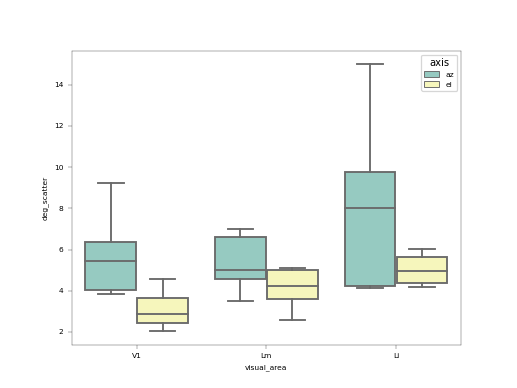

In [157]:
fig, ax= pl.subplots()
sns.boxplot(x='visual_area', y='deg_scatter', hue='axis', data=plotd, 
            order=visual_areas, palette='Set3', fliersize=0)
pl.subplots_adjust(bottom=0.2, right=0.8)

# Check rfs-5 vs rfs-10

In [158]:
has_rfs5_andrfs10 = pd.concat([g for (va, dk), g \
                        in scatter_pass_regr.groupby(['visual_area', 'datakey'])
                        if 'rfs' in g['experiment'].values \
                               and 'rfs10' in g['experiment'].values])
has_both_counts =  pd.concat([g for (va, dk), g \
                        in count_dev.groupby(['visual_area', 'datakey'])
                        if 'rfs' in g['experiment'].values \
                               and 'rfs10' in g['experiment'].values])


<IPython.core.display.Javascript object>


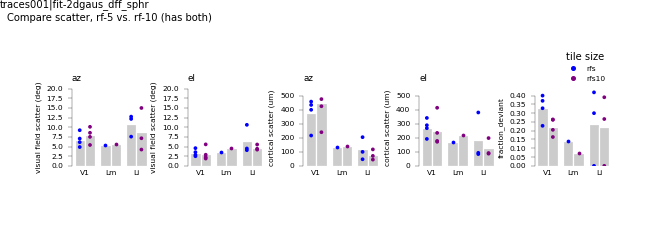

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/scipy/stats/morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


   t_stat     p_val visual_area
0     0.0  0.125000          V1
1     0.0  1.000000          Lm
2     0.0  0.179712          Li


In [159]:
exp_colors = {'rfs': 'blue', 'rfs10': 'purple'}

plotd_exp = has_rfs5_andrfs10.groupby(['visual_area', 'datakey', 'axis', 'experiment'])\
                .mean().reset_index()
# print(plotd[['visual_area', 'datakey']]\
#       .drop_duplicates().groupby(['visual_area']).count()['datakey'].to_markdown())
stats_list=[]
fig, axn = pl.subplots(1,5, figsize=(8, 3))
fig.patch.set_facecolor('w')
ai=0
for mi, metric in enumerate(['deg_scatter', 'dist_scatter']):
    for ei, (exp, exp_df) in enumerate(plotd_exp.groupby('axis')):
        ax=axn[ai]
        ylabel = 'cortical scatter (um)' if metric=='dist_scatter' \
                    else 'visual field scatter (deg)'
        ax.set_title(exp, loc='left', fontsize=7)
        sns.barplot(x='visual_area', y=metric, data=exp_df, ax=ax,
                  order=visual_areas, hue='experiment', 
                    palette={'rfs': [0.8]*3, 'rfs10': [0.8]*3}, 
                    edgecolor='w', ci=None)
        sns.stripplot(x='visual_area', y=metric, data=exp_df, ax=ax,
                  order=visual_areas, hue='experiment', dodge=True,
                  jitter=False, size=3,
                  palette=exp_colors)
        ax.legend_.remove()
        ax.set_box_aspect(1)
        ax.set_ylabel(ylabel)
        if metric=='dist_scatter':
            offset=100; h=20;
            ax.set_ylim([0, 550])
        else:
            ax.set_ylim([0, 20])
            offset=10; h=.1;
        ai+=1
        try:
            stats_ = pstats.paired_ttests(exp_df, metric=metric, c1='rfs', c2='rfs10',
                                    compare_var='experiment', ttest=False)
            stats_['metric'] = metric
            stats_list.append(stats_)
            pplot.annotate_sig_on_paired_plot(ax, exp_df, stats_, 
                                              metric, offset=offset, h=h)
        except Exception as e:
            continue
statdf = pd.concat(stats_list, axis=0)
    
ax=axn[-1]
sns.stripplot(x='visual_area', y='fraction_deviant', data=has_both_counts, ax=ax,
              hue='experiment', palette=exp_colors, dodge=True, 
              order=visual_areas, jitter=False,size=3)
sns.barplot(x='visual_area', y='fraction_deviant', data=has_both_counts, ax=ax,
              hue='experiment', palette={'rfs': [0.8]*3, 'rfs10': [0.8]*3}, 
             edgecolor='w',ci=None, order=visual_areas)
pplot.crop_legend_labels(ax, 2,start_ix=0, bbox_to_anchor=(1, 1), loc='upper left',
        fontsize=6, title='tile size', markerscale=0.5)
stats_ = pstats.paired_ttests(has_both_counts, metric='fraction_deviant', 
                              c1='rfs', c2='rfs10',
                              compare_var='experiment', ttest=False)
# stats_['metric'] = metric
ax.set_box_aspect(1)
print(stats_)
pplot.annotate_sig_on_paired_plot(ax, has_both_counts, stats_, 'fraction_deviant', 
                                  offset=0.05, h=0.05)


pl.subplots_adjust(left=0.1, right=0.8, wspace=0.2, bottom=0.2, top=0.85)
sns.despine(bottom=True, trim=True)
for ax in axn.flat:
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xlabel('')  

# custom legend
leg_h = pplot.custom_legend_markers(colors=[exp_colors['rfs'], exp_colors['rfs10']],
                                   labels=['rfs', 'rfs10'],
                                   markers='o', lws=0)
axn[-1].legend(handles=leg_h, bbox_to_anchor=(1,1), frameon=False,
                    loc='lower right', fontsize=6, markerscale=0.5, title='tile size')

fig.text(0.01, 0.92, 'Compare scatter, rf-5 vs. rf-10 (has both)', fontsize=8)
pl.subplots_adjust(left=0.1, right=0.85, bottom=0.2, wspace=0.5)

pplot.label_figure(fig, data_id)

figname = 'scatter_compare_rf5-rf10_reliable'
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

In [160]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

#perform two-way ANOVA
model = ols('deg_scatter ~ C(visual_area) + C(axis) + C(visual_area):C(axis)', \
            data=plotd).fit()
sm.stats.anova_lm(model, typ=2)


,sum_sq,df,F,PR(>F)
C(visual_area),38.659795,2.0,3.302949,0.047581
C(axis),57.218497,1.0,9.777071,0.003382
C(visual_area):C(axis),7.840751,2.0,0.669885,0.517707
Residual,222.387952,38.0,NaN,NaN
